In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import zipfile
import matplotlib.pyplot as plt
import gdown
import pandas as pd

In [ ]:
# Define constants
image_size = (214, 214)
batch_size = 128
epochs = 20
num_classes = 2  # Violence and NonViolence

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Replace 'YOUR_FILE_ID' with your Google Drive file ID
file_id = '14HnAWe3ZiZP8qlUcdASZZIFkX2kYoCN_'

# Check sharing settings
gdown.download("https://drive.usercontent.google.com/download?id=14HnAWe3ZiZP8qlUcdASZZIFkX2kYoCN_&export=download&authuser=0&confirm=t&uuid=66e9a259-6328-4a71-aed4-d8d4fe03b34e&at=APZUnTU_y8IjOEAzBe3pWZY1JWT4:1694941568953" + file_id, quiet=False)

Downloading...
From: https://drive.usercontent.google.com/download?id=14HnAWe3ZiZP8qlUcdASZZIFkX2kYoCN_&export=download&authuser=0&confirm=t&uuid=66e9a259-6328-4a71-aed4-d8d4fe03b34e&at=APZUnTU_y8IjOEAzBe3pWZY1JWT4:169494156895314HnAWe3ZiZP8qlUcdASZZIFkX2kYoCN_
To: /content/download?id=14HnAWe3ZiZP8qlUcdASZZIFkX2kYoCN_&export=download&authuser=0&confirm=t&uuid=66e9a259-6328-4a71-aed4-d8d4fe03b34e&at=APZUnTU_y8IjOEAzBe3pWZY1JWT4:169494156895314HnAWe3ZiZP8qlUcdASZZIFkX2kYoCN_
100%|██████████| 71.0M/71.0M [00:03<00:00, 21.1MB/s]


'download?id=14HnAWe3ZiZP8qlUcdASZZIFkX2kYoCN_&export=download&authuser=0&confirm=t&uuid=66e9a259-6328-4a71-aed4-d8d4fe03b34e&at=APZUnTU_y8IjOEAzBe3pWZY1JWT4:169494156895314HnAWe3ZiZP8qlUcdASZZIFkX2kYoCN_'

In [ ]:
# Define the file URL (change this to your dataset URL)
file_url = 'https://drive.usercontent.google.com/download?id=14HnAWe3ZiZP8qlUcdASZZIFkX2kYoCN_&export=download&authuser=0&confirm=t&uuid=e14d0896-4205-4df8-8044-546af255e003&at=APZUnTWKaBE7PlVLChsSJSwgGBbM:1694323959491'

# Define the destination file path
output_file = '/content/dataset.zip'  # Change this to your desired destination

# Download the file
gdown.download(file_url, output_file, quiet=False)

# Unzip the file
with zipfile.ZipFile(output_file, 'r') as zip_ref:
    zip_ref.extractall('/content/')

Downloading...
From: https://drive.usercontent.google.com/download?id=14HnAWe3ZiZP8qlUcdASZZIFkX2kYoCN_&export=download&authuser=0&confirm=t&uuid=e14d0896-4205-4df8-8044-546af255e003&at=APZUnTWKaBE7PlVLChsSJSwgGBbM:1694323959491
To: /content/dataset.zip
100%|██████████| 71.0M/71.0M [00:00<00:00, 112MB/s]


In [ ]:
# Now you can access the extracted dataset folder
data_dir = '/content'

In [ ]:
# Construct file paths for the CSV files
train_csv = os.path.join(data_dir, 'train', '_annotations.csv')
test_csv = os.path.join(data_dir, 'test', '_annotations.csv')
valid_csv = os.path.join(data_dir, 'valid', '_annotations.csv')

In [ ]:
# Read the CSV files for train, test, and valid
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)
valid_df = pd.read_csv(valid_csv)

In [ ]:
# Create ImageDataGenerator for data augmentation (if needed)
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
)

In [ ]:
# Create generators for training, validation, and testing
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(data_dir, 'train'),
    x_col="filename",
    y_col="class",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
)

Found 2692 validated image filenames belonging to 2 classes.


In [ ]:
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(data_dir, 'train'),
    x_col="filename",
    y_col="class",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
)

Found 672 validated image filenames belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=os.path.join(data_dir, 'test'),
    x_col="filename",
    y_col="class",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
)

Found 441 validated image filenames belonging to 2 classes.


In [ ]:
# Create ResNet-50 model
base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=valid_generator.samples // batch_size
)

Epoch 1/20
21/21 [==============================] - 109s 3s/step - loss: 1.0758 - accuracy: 0.5987 - val_loss: 35.9467 - val_accuracy: 0.5500
Epoch 2/20
21/21 [==============================] - 51s 2s/step - loss: 0.6234 - accuracy: 0.6751 - val_loss: 22.7772 - val_accuracy: 0.5562
Epoch 3/20
21/21 [==============================] - 54s 3s/step - loss: 0.5535 - accuracy: 0.7032 - val_loss: 27.0834 - val_accuracy: 0.4016
Epoch 4/20
21/21 [==============================] - 54s 3s/step - loss: 0.5378 - accuracy: 0.7235 - val_loss: 5.5104 - val_accuracy: 0.5391
Epoch 5/20
21/21 [==============================] - 55s 3s/step - loss: 0.5411 - accuracy: 0.7219 - val_loss: 4.9178 - val_accuracy: 0.5766
Epoch 6/20
21/21 [==============================] - 55s 3s/step - loss: 0.5185 - accuracy: 0.7363 - val_loss: 82.9595 - val_accuracy: 0.5016
Epoch 7/20
21/21 [==============================] - 56s 3s/step - loss: 0.5243 - accuracy: 0.7395 - val_loss: 32.2387 - val_accuracy: 0.5531
Epoch 8/20
21/

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

4/4 [==============================] - 4s 963ms/step - loss: 2.5270 - accuracy: 0.6077
Test Accuracy: 60.77%


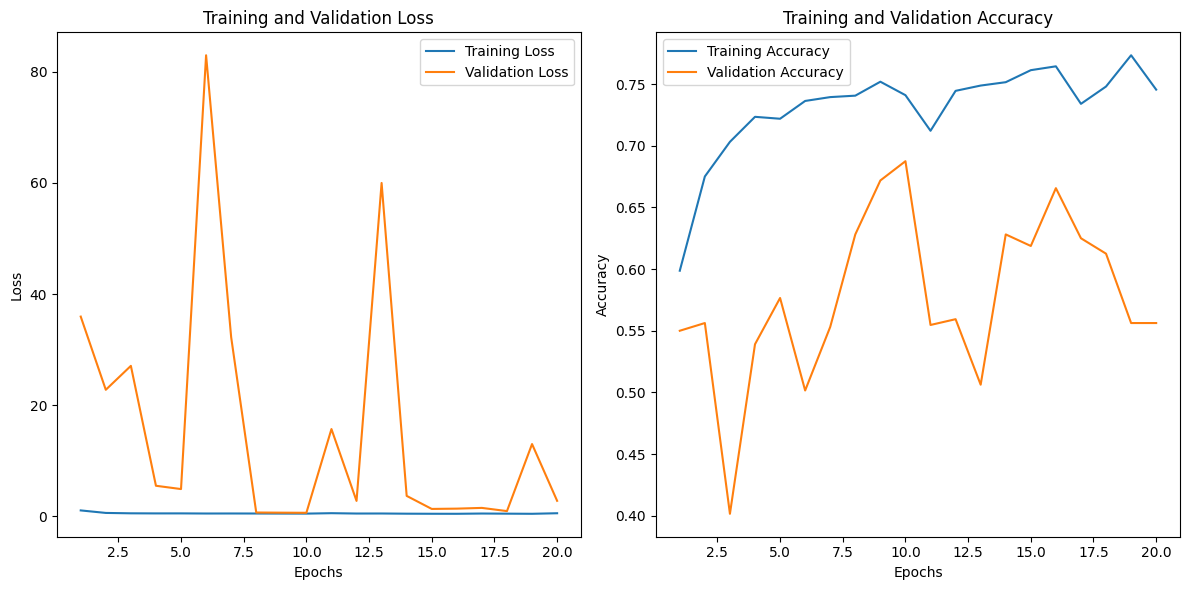

In [ ]:
# Access training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_loss, label='Training Loss')
plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()